In [1]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.signal import welch, firwin, filtfilt, hilbert
from scipy.stats.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency
from time import gmtime
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.cluster import KMeans
from scipy.stats import wilcoxon

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=3)

In [149]:
file = "/Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_without_torpor.csv"

In [150]:
data = pd.read_csv(file)

dG - отклонение ускорения в момент измерения от 0 (ускорения свободного падения); если животное падает, то ускорение животного равно G и соответственно dG будет равно 1

dF1, dF2 - изменение направления вектора ускорения, причем dF1 - изменение за время между двумя измерениями (1 минута), а  dF2 - изменение между двумя измерениями с интервалом 1 мс - если оно не равно 0, то обычно животное изменяет свое положение.
 
Все показатели измеряются раз в минуту, если период измерения  указан больше, чем минута, то показатели усредняются за этот период. Если надо, то изготовитель может прислать точную формулу расчета этих показателей.

In [151]:
data.head()

,Page,Record,Period,Year,Month,Day,Hour,Minute,Second,Ubat,T,dG,dF1,dF2
0,8,13,10,2019,1,19,3,45,0,3.0,36.489,0.031,11,3
1,8,14,10,2019,1,19,3,55,0,3.0,36.758,0.062,17,6
2,9,1,10,2019,1,19,4,5,0,3.0,36.731,0.078,12,4
3,9,2,10,2019,1,19,4,15,0,3.0,36.699,0.094,1,0
4,9,3,10,2019,1,19,4,25,0,3.0,36.673,0.094,3,1


In [26]:
def normalize(df):
    return (df - df.mean()) / df.std()

In [246]:
x = normalize(data.iloc[:, -3])
y = normalize(data.iloc[:, -4])

In [260]:
time_array = np.arange(x.shape[0])

gap = 6 * 24 # set size of the rolling window 

p = np.zeros(x.shape[0]-gap) # p-value vector
c = np.zeros(x.shape[0]-gap) # statistic vector

# calculate the rolling corelation coefficient
for i in np.arange(x.shape[0]-gap):
    ans = spearmanr(x[i:i+gap], y[i:i+gap])
    c[i] = ans[0] 
    p[i] = ans[1]
    
p_adjusted = multipletests(p, method='bonferroni')[1]

c1 = np.zeros(x.shape[0]-gap)
c2 = np.zeros(x.shape[0]-gap)
c3 = np.zeros(x.shape[0]-gap)

c_green = np.zeros(x.shape[0]-gap)
c_yellow = np.zeros(x.shape[0]-gap)
c_red = np.zeros(x.shape[0]-gap)

c1[(p_adjusted < 0.05) & (np.abs(c) >= 0.9)] = 1
c2[(p_adjusted < 0.05) & (np.abs(c) >= 0.7) & (np.abs(c) < 0.9)] = 1
c3[(p_adjusted < 0.05) & (np.abs(c) >= 0.6) & (np.abs(c) < 0.7)] = 1
c1[c1 < 1] = 0
c2[c2 < 1] = 0
c3[c3 < 1] = 0

num = [c1, c2, c3]
col = [c_green, c_yellow, c_red]

z = list(zip(num, col))

counter = 0

for unit in z:
    for i in range(len(unit[0])):
        if unit[0][i] == 0:
            if counter == 0:
                unit[1][i] = NAN
            else:
                unit[1][i] = time_array[i]
                counter -= 1
        else:
            unit[1][i] = time_array[i]
            counter = gap

z[2][1][z[1][1] == 1] = nan
z[1][1][z[0][1] == 1] = nan
z[2][1][z[0][1] == 1] = nan

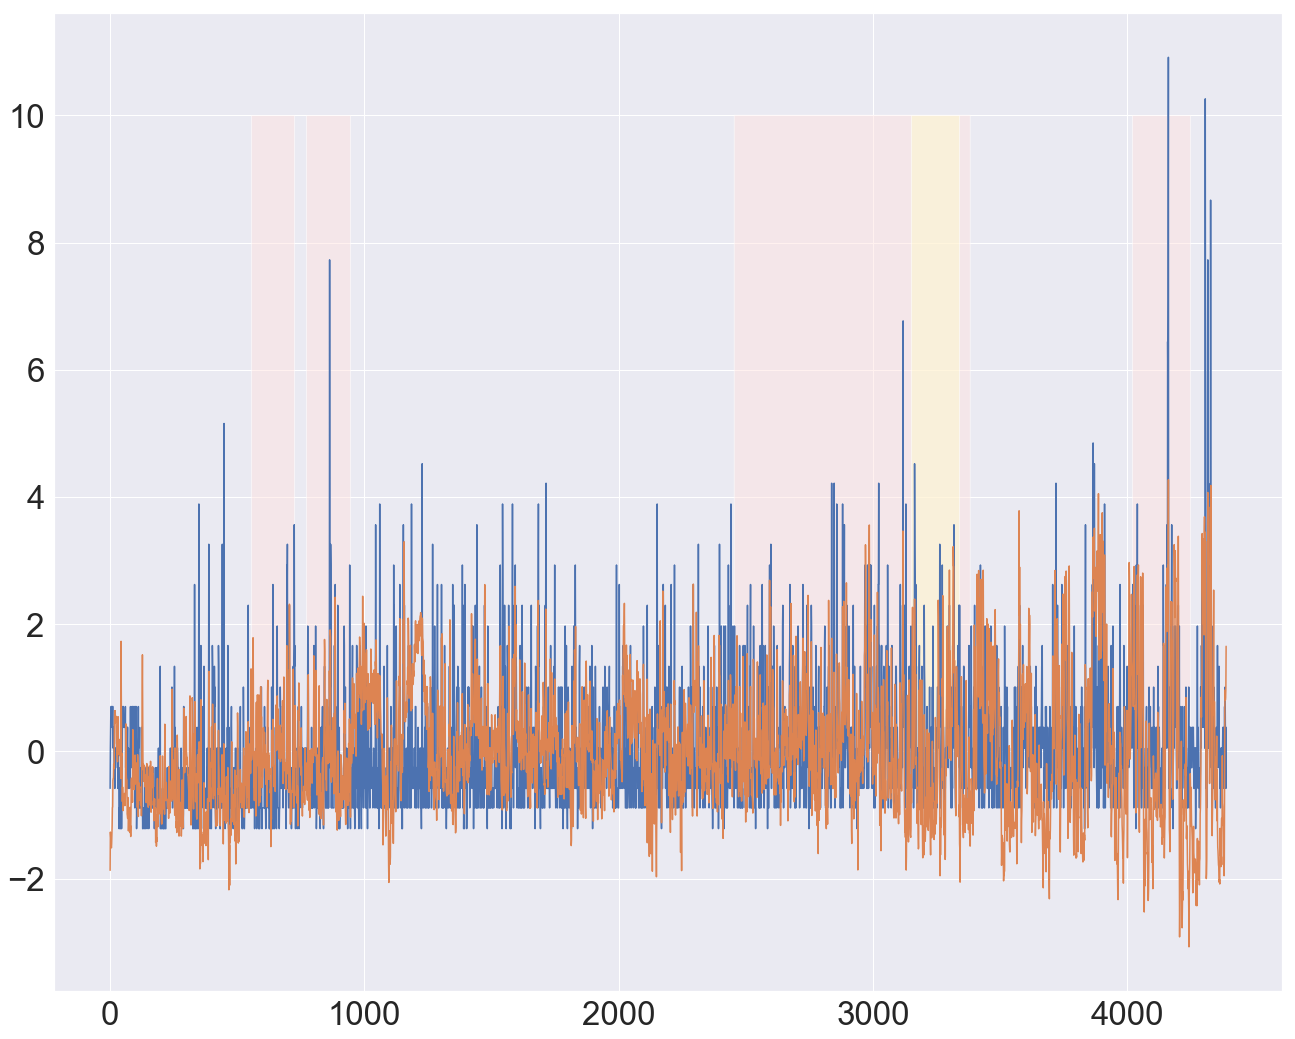

In [261]:
hight = 10
skip_start = 0
plt.fill_between(z[2][1][:], np.ones(z[0][1][:].shape[0])*hight, alpha=0.5, facecolor="mistyrose", label = "70% > Абсолютная Корреляция Пирсона > 60%")
plt.fill_between(z[1][1][:], np.ones(z[0][1][:].shape[0])*hight, alpha=0.5, facecolor="lemonchiffon", label = "90% > Абсолютная Корреляция Пирсона > 70 %")
plt.fill_between(z[0][1][:], np.ones(z[0][1][:].shape[0])*hight, alpha=0.5, facecolor="lightgreen", label = "Абсолютная Корреляция Пирсона > 90 %")
plt.plot(x)
plt.plot(y)

In [3]:
path = "/Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/"

In [4]:
raw_data = mne.io.read_raw_edf(path+file)
df = pd.DataFrame(raw_data.get_data([0, 2]), index=[raw_data.ch_names[0], raw_data.ch_names[2]]).T

NameError: name 'file' is not defined

In [5]:
raw_data = mne.io.read_raw_edf(path+os.listdir(path)[0])

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/31-01-2019_13-39.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-00355bfeffe9>:1: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+os.listdir(path)[0])


In [27]:
df = pd.DataFrame(raw_data.get_data().T)

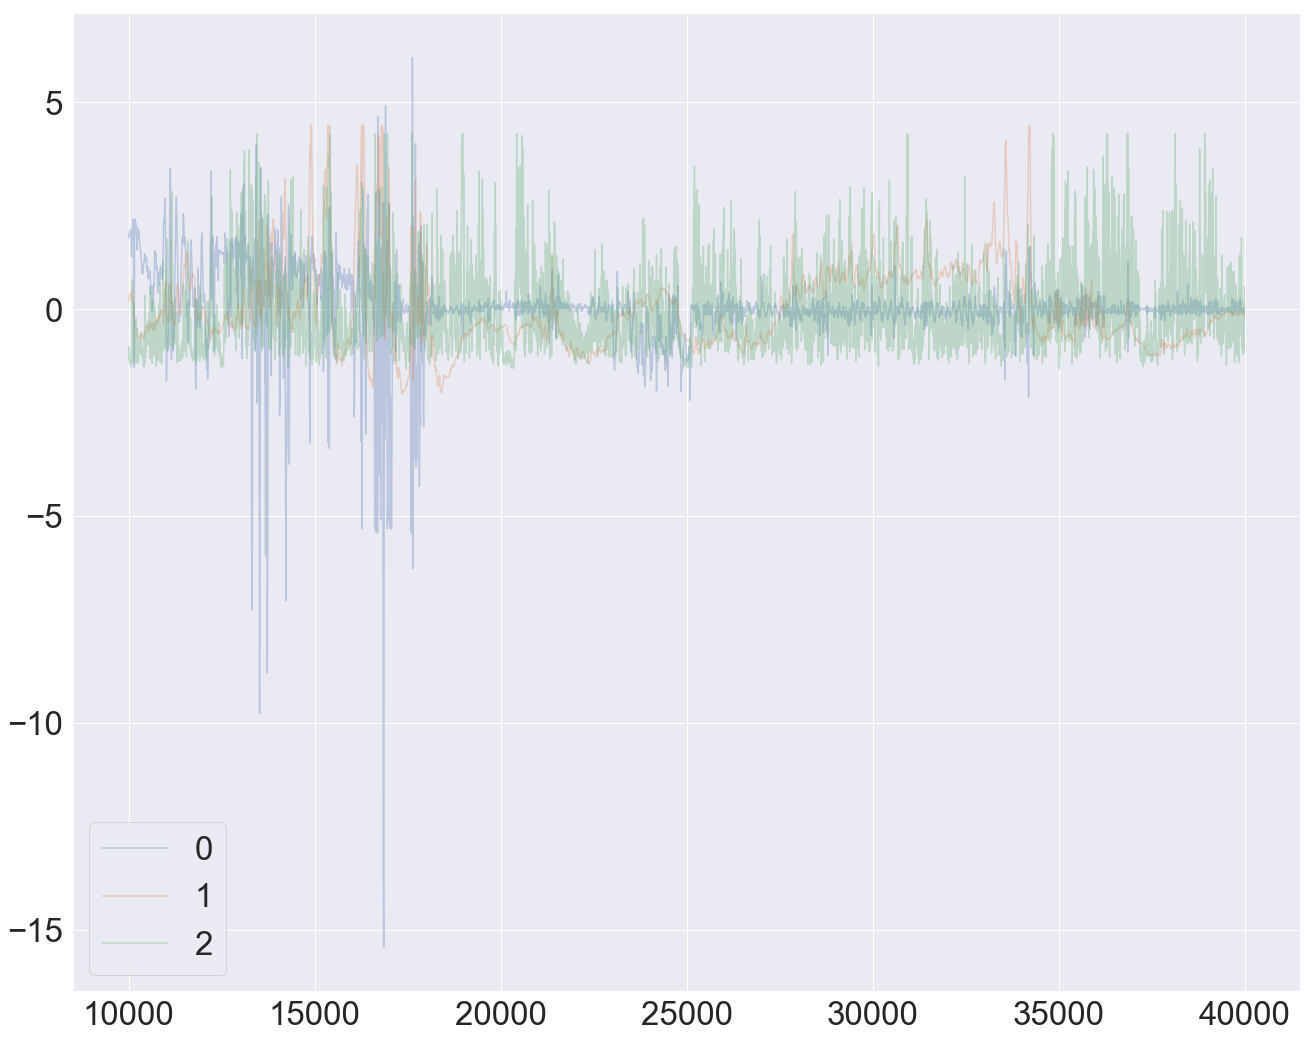

In [42]:
normalize(df.iloc[10000:40000, :]).plot(alpha=0.3)